In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from westgate.flaml_model import *
import pandas as pd
from westgate.combochart import combo_chart

In [7]:
accepted_df = pd.read_csv('../data/AttributesLoans2022.csv', encoding='latin')
refused_raw_df = pd.read_csv('../data/refusal2022.csv', encoding='latin')

C:\Users\karim\AppData\Local\Temp\ipykernel_31696\3967161521.py:1: DtypeWarning: Columns (741) have mixed types. Specify dtype option on import or set low_memory=False.
  accepted_df = pd.read_csv('../data/AttributesLoans2022.csv', encoding='latin')


In [5]:
print(refused_raw_df.iloc[0]['dob'])

1976-07-24


In [8]:
refused_raw_df['recurring_deposits_90_days'] = (
    refused_raw_df['recurring_deposits_current_month'] + 
    refused_raw_df['recurring_deposits_previous_month'] +
    refused_raw_df['recurring_deposits_2_months_ago']
)

refused_raw_df['sum_micro_loans_60_days'] = (
    refused_raw_df['sum_micro_loan_payments_current_month'] + 
    refused_raw_df['sum_micro_loan_payments_previous_month'] 
)

refused_raw_df['recurring_deposits_90_days'] = (
    refused_raw_df['recurring_deposits_current_month'] + 
    refused_raw_df['recurring_deposits_previous_month'] +
    refused_raw_df['recurring_deposits_2_months_ago']
)

refused_raw_df['sum_micro_loans_60_days'] = (
    refused_raw_df['sum_micro_loan_payments_current_month'] + 
    refused_raw_df['sum_micro_loan_payments_previous_month'] 
)

In [9]:
print('# loans before auto-refusal: ' + str(len(refused_raw_df)))

refused_df = refused_raw_df[refused_raw_df['account_age_days'] >= 85]

refused_df = refused_df[refused_df['count_nsf_90_days'] <= 8]

refused_df = refused_df[refused_df['count_nsf_30_days'] <= 6]

refused_df = refused_df[refused_df['count_stop_payment_90_days'] <= 4]

#refused_df = refused_df[refused_df['recurring_deposits_90_days']/3.0 >= 1800] <-- filers way too much

#refused_df = refused_df[refused_df['sum_micro_loans_60_days'] <= 1000]

print('# loans after auto-refusal: ' + str(len(refused_df)))

# loans before auto-refusal: 37398
# loans after auto-refusal: 28579


In [10]:
len(accepted_df)

10098

In [11]:
default_model = UWModel(experiment_id='default_1.0', basefolder='../default_model/')
refusal_model = LendingModel(experiment_id='refusal_0.2')

In [12]:
accepted_filtered_df = default_model.filter_df(accepted_df)

Rows with 'account_age_days' column not positive will be discarded.


In [13]:
len(accepted_filtered_df)

9507

In [14]:
accepted_filtered_df['refusal'] = 0
refused_df['refusal'] = 1

df = pd.concat([accepted_filtered_df, refused_df])

In [13]:
len(df)

38086

In [15]:
df['refusal'].value_counts(normalize=True)

refusal
1    0.750381
0    0.249619
Name: proportion, dtype: float64

In [24]:
'dob' in df.columns

True

In [43]:
X_train, X_test, y_train, y_test, extra = refusal_model.split_data(df, split_criteria=0.15)

In [44]:
len(X_train)

32373

In [45]:
'dob' in X_train.columns

True

In [46]:
X_train, X_test = refusal_model.feature_engineer(X_train, X_test)

Error calculating age with dob ########## and request_date 2022-06-15 00:00:00
Unknown string format: ##########
Error calculating age with dob ########## and request_date 2022-09-14 00:00:00
Unknown string format: ##########
Error calculating age with dob ########## and request_date 2022-10-03 00:00:00
Unknown string format: ##########
Error calculating age with dob ########## and request_date 2022-10-06 00:00:00
Unknown string format: ##########


In [47]:
len(X_train),len(y_train)

(32373, 32373)

In [48]:
filter = ~X_train['age'].isna()
X_train = X_train.loc[filter]
y_train = y_train.loc[filter]

In [49]:
len(X_train), len(y_train)

(32370, 32370)

In [21]:
X_train.columns

Index(['account_age_days', 'average_monthly_recurring_transfers_in_complex',
       'average_monthly_recurring_transfers_out_complex', 'count_active_days',
       'count_nsf_30_days', 'count_nsf_90_days', 'count_stop_payment_90_days',
       'recurring_deposits_2_months_ago', 'recurring_deposits_current_month',
       'recurring_deposits_previous_month',
       'sum_disability_income_2_months_ago',
       'sum_disability_income_current_month',
       'sum_disability_income_previous_month',
       'sum_employer_income_2_months_ago', 'sum_employer_income_current_month',
       'sum_employer_income_previous_month',
       'sum_employment_insurance_income_2_months_ago',
       'sum_employment_insurance_income_current_month',
       'sum_employment_insurance_income_previous_month',
       'sum_government_income_2_months_ago',
       'sum_government_income_current_month',
       'sum_government_income_previous_month', 'sum_loan_deposits_30_days',
       'sum_loan_deposits_60_days', 'sum_loan

In [50]:
X_train.isna().sum().sum()

0

In [51]:
r = X_train, y_train, X_test, y_test, extra

In [52]:
len(X_test), len(y_test)

(5713, 5713)

In [53]:
y_test.value_counts(normalize=True)

refusal
1    0.749869
0    0.250131
Name: proportion, dtype: float64

X_train shape: (32370, 36)
X_test shape: (5713, 36)



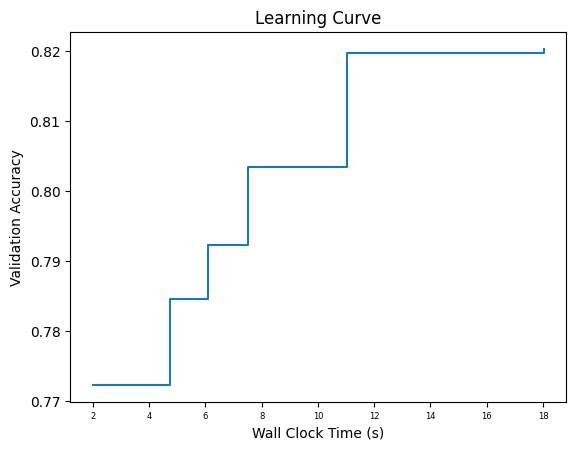

Actual [TEST]:
4284 (75.0%)
Predicted [TEST]:
4285 (75.0%)

y_pred_proba distribution:
(-0.000262, 0.1]     132
(0.1, 0.2]            19
(0.2, 0.3]            70
(0.3, 0.399]         309
(0.399, 0.499]       415
(0.499, 0.599]       533
(0.599, 0.698]       600
(0.698, 0.798]       674
(0.798, 0.898]       789
(0.898, 0.997]      2172
Name: count, dtype: int64

Best validation loss: -0.17972864508300804


              precision    recall  f1-score   support

           0       0.56      0.56      0.56      1429
           1       0.85      0.85      0.85      4284

    accuracy                           0.78      5713
   macro avg       0.71      0.71      0.71      5713
weighted avg       0.78      0.78      0.78      5713

Normalized confusion matrix:
[[0.55913226 0.44086774]
 [0.1468254  0.8531746 ]]




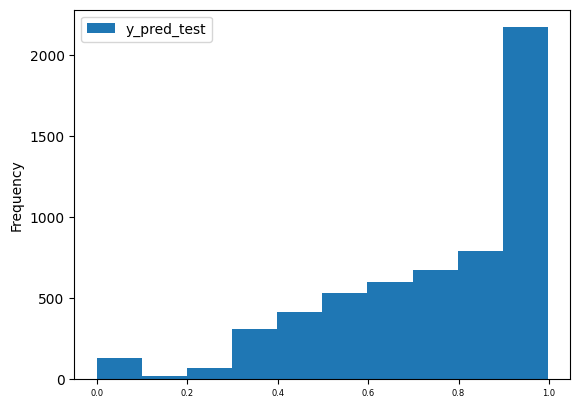

In [73]:
y_pred_proba, y_pred, extra = refusal_model.fit(*r, 
                                                time_budget=20, 
                                                percentile=0.25)

In [84]:
type(refusal_model)

westgate.flaml_model.LendingModel

In [85]:
y_pred_proba_check = refusal_model.predict_proba(X_test, filter=False, engineer=False)

<Axes: ylabel='Frequency'>

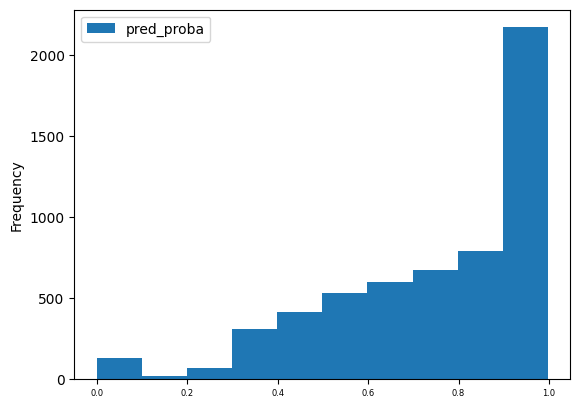

In [86]:
y_pred_proba_check.plot.hist()

In [56]:
perf_df = pd.DataFrame({'y_pred': y_pred_proba, 'y_test': y_test})

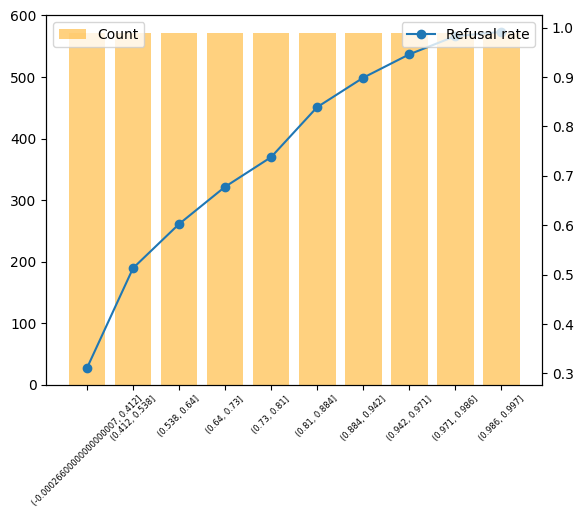

In [57]:
fig = combo_chart(perf_df, xvar='y_pred', q=10, yvar='y_test', ylabel='Refusal rate')

In [87]:
X_full = pd.concat([X_train, X_test])
y_full = pd.concat([y_train, y_test])

In [88]:
refusal_model.automl.retrain_from_log(
    'log_refusal_0.2.log',
    X_full,
    y_full,
    train_best=True,
    train_full=True,
    time_budget=20
)

[flaml.automl.logger: 04-07 18:35:41] {804} INFO - log file name log_refusal_0.2.log
[flaml.automl.logger: 04-07 18:35:41] {857} INFO - estimator = xgboost, config = {'n_estimators': 12, 'max_leaves': 24, 'min_child_weight': 1.198219708065302, 'learning_rate': 0.5917585189324418, 'subsample': 0.9986444603462741, 'colsample_bylevel': 1.0, 'colsample_bytree': 0.9468117873770695, 'reg_alpha': 0.026629132162083402, 'reg_lambda': 0.4001243226017511}, #training instances = 38083
[flaml.automl.logger: 04-07 18:35:42] {890} INFO - retrain from log succeeded


18.020979642868042

In [89]:
refusal_model.save()

In [90]:
y_pred_proba = refusal_model.predict_proba(X_full, filter=False, engineer=False)['pred_proba']

<Axes: ylabel='Frequency'>

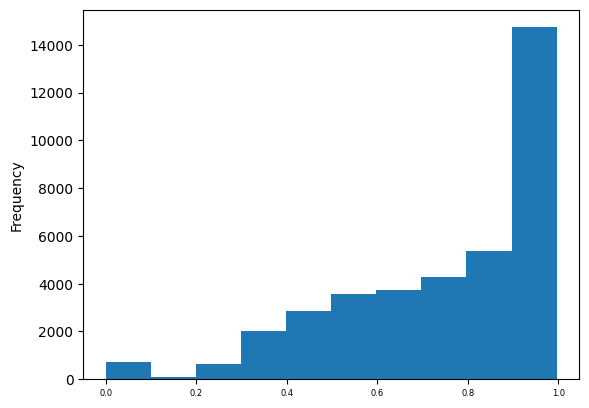

In [91]:
y_pred_proba.plot.hist()

In [92]:
y_pred_proba_bins = pd.cut(y_pred_proba, 10, duplicates = 'drop')
print('\ny_pred_proba distribution:')
print(y_pred_proba_bins.value_counts())


y_pred_proba distribution:
pred_proba
(0.897, 0.996]         14732
(0.797, 0.897]          5383
(0.698, 0.797]          4287
(0.598, 0.698]          3740
(0.498, 0.598]          3577
(0.399, 0.498]          2876
(0.299, 0.399]          2020
(-0.000731, 0.0999]      743
(0.199, 0.299]           627
(0.0999, 0.199]           98
Name: count, dtype: int64


In [95]:
y_pred_proba

7793     0.541584
12018    0.350354
1994     0.466411
2949     0.178315
29957    0.986973
           ...   
4950     0.673379
9231     0.799435
23366    0.650362
6905     0.784938
4399     0.969097
Name: pred_proba, Length: 38083, dtype: float32

In [96]:
percentiles = np.percentile(y_pred_proba, [70, 80, 90])
percentiles

array([0.940483  , 0.97023414, 0.98572879])

Testing saving/loading of the model

In [93]:
refusal_model.save()

In [3]:
refusal_model_loaded = load_model('refusal_0.2')

In [5]:
refusal_model_loaded.feat_imp()

,variable,imp
16,sum_employer_income_previous_month,0.268047
6,count_nsf_90_days,0.098772
29,sum_micro_loan_payments_2_months_ago,0.087500
14,sum_employer_income_2_months_ago,0.053099
1,account_age_days,0.041415
30,sum_micro_loan_payments_current_month,0.035048
23,sum_loan_deposits_30_days,0.032538
28,sum_loan_payments_previous_month,0.028527
35,age,0.026591
15,sum_employer_income_current_month,0.021908


In [33]:
refusal_model_loaded.predict_proba(X_test, filter=False, engineer=False)

,pred_proba
31575,0.017699
15206,0.058634
24651,0.050830
33270,0.008079
28292,0.012915
...,...
23590,0.036100
3890,0.027702
31844,0.030680
28716,0.945993


In [4]:
len(refusal_model_loaded.features_in)

35

In [16]:
preds_full = refusal_model_loaded.predict_proba(df, filter=False, engineer=True)

Error calculating age with dob ########## and request_date 2022-06-15 00:00:00
Unknown string format: ##########
Error calculating age with dob ########## and request_date 2022-09-14 00:00:00
Unknown string format: ##########
Error calculating age with dob ########## and request_date 2022-10-03 00:00:00
Unknown string format: ##########
Error calculating age with dob ########## and request_date 2022-10-06 00:00:00
Unknown string format: ##########


In [17]:
preds_full

,pred_proba
0,0.030537
1,0.030680
2,0.035419
3,0.967385
5,0.012777
...,...
37391,0.037545
37392,0.027702
37395,0.051709
37396,0.063490


<Axes: ylabel='Frequency'>

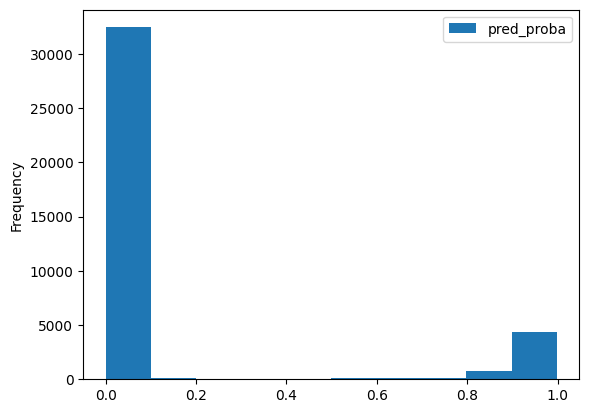

In [19]:
preds_full.plot.hist()

In [22]:
p25_2022 = np.percentile(preds_full['pred_proba'], 25)
p25_2022

0.019917527213692665

In [23]:
y_pred_proba_bins = pd.cut(preds_full['pred_proba'], 10, duplicates = 'drop')
print('\ny_pred_proba distribution:')
print(y_pred_proba_bins.value_counts())


y_pred_proba distribution:
pred_proba
(-0.000866, 0.0999]    32438
(0.898, 0.997]          4398
(0.798, 0.898]           749
(0.698, 0.798]           158
(0.599, 0.698]            82
(0.499, 0.599]            81
(0.0999, 0.2]             74
(0.399, 0.499]            58
(0.2, 0.299]              31
(0.299, 0.399]            17
Name: count, dtype: int64
